<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_auxiliary_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple template for the Variational Autoencoder Model (VAE):

https://arxiv.org/pdf/1312.6114.pdf

https://arxiv.org/pdf/1907.04809.pdf (iVAE)

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
df1 = pd.read_csv("dge.txt",delimiter="\t")
df2 = pd.read_csv("geometry.txt",delimiter="\t")

In [0]:
X = df1.to_numpy()

In [0]:
U = df2.to_numpy()
U = U[0:X.shape[0],:]

In [130]:
U[0:2]

array([['-194.04 0.22 30.2'],
       ['-203.32 1.93 20.08']], dtype=object)

In [0]:
U_temp = []
for i in range(X.shape[0]):
  ss = U[i][0]
  ff = np.fromstring(ss, dtype=float, sep=' ')
  U_temp.append(ff)

U = np.array(U_temp)

In [133]:
print(X.shape)
print(U.shape)

(3039, 84)
(3039, 3)


In [0]:
def normalize_data(X):
  return (X-np.mean(X,axis=0)/np.std(X,axis=0))

In [0]:
#Multivariate diagional
def create_encoder(x, latent_size):
  act = tf.nn.leaky_relu
  
  x = tf.layers.dense(x, 32, act)
  x = tf.layers.dense(x, 16, act)
  x = tf.layers.dense(x, 8, act)
  loc = tf.layers.dense(x,latent_size)
  log_variance = tf.layers.dense(x, latent_size)
  scale = tf.nn.softplus(log_variance)
  return tfd.MultivariateNormalDiag(loc, scale)

def create_prior(latent_size, u):
  act = tf.nn.leaky_relu
  
  u = tf.layers.dense(u, 5, act)
  u = tf.layers.dense(u, 5, act)
  u = tf.layers.dense(u, 3, act)
  loc = tf.layers.dense(u, latent_size)
  log_variance = tf.layers.dense(u, latent_size)
  scale = tf.nn.softplus(log_variance)
  return tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)

def create_decoder(x, output_size):
  act = tf.nn.leaky_relu
  
  x = tf.layers.dense(x, 8, act)
  x = tf.layers.dense(x, 16, act)
  x = tf.layers.dense(x, 32, act)
  loc = tf.layers.dense(x, output_size)
  return loc

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 3], name='u_in')
u = u_in
x = tf.concat((x_in, u), axis=-1)

latent_size = 3

latent_prior = create_prior(latent_size, u)
latent_posterior = create_encoder(x, latent_size=latent_size)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior_loc = create_decoder(latent_sampled, X.shape[1])


rec_loss = tf.losses.mean_squared_error(x_out, posterior_loc)
#kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=0.001
kl_loss = beta*kl


loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [237]:
n_epochs = 400
batch_size = 16
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      latent_mean_, latent_sampled_= sess.run([latent_mean, latent_sampled], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()

epoch: 1, total_loss: 6320588.98, rec_loss: 0.22, time: 1.36
epoch: 10, total_loss: 6841.14, rec_loss: 0.03, time: 7.77
epoch: 20, total_loss: 512.99, rec_loss: 0.03, time: 8.90
epoch: 30, total_loss: 87.71, rec_loss: 0.03, time: 8.77
epoch: 40, total_loss: 29.84, rec_loss: 0.02, time: 8.69
epoch: 50, total_loss: 12.38, rec_loss: 0.02, time: 8.66
epoch: 60, total_loss: 7.00, rec_loss: 0.02, time: 8.86
epoch: 70, total_loss: 3.82, rec_loss: 0.02, time: 8.91
epoch: 80, total_loss: 2.62, rec_loss: 0.02, time: 8.96
epoch: 90, total_loss: 1.69, rec_loss: 0.01, time: 8.86
epoch: 100, total_loss: 1.49, rec_loss: 0.01, time: 8.86
epoch: 110, total_loss: 0.20, rec_loss: 0.01, time: 8.81
epoch: 120, total_loss: 0.16, rec_loss: 0.01, time: 8.60
epoch: 130, total_loss: 0.06, rec_loss: 0.01, time: 8.62
epoch: 140, total_loss: 0.08, rec_loss: 0.01, time: 8.97
epoch: 150, total_loss: 0.02, rec_loss: 0.01, time: 8.69
epoch: 160, total_loss: 0.02, rec_loss: 0.01, time: 8.65
epoch: 170, total_loss: 0.02

In [238]:
U[:,0]

array([-194.04, -203.32, -200.25, ..., -118.4 ,  -20.05,   -0.25])

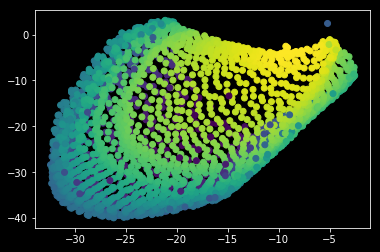

In [244]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=U[:,0], cmap='viridis');

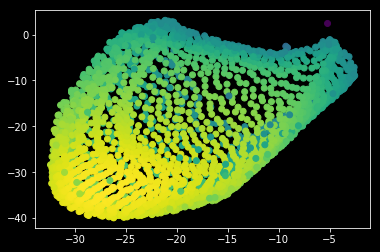

In [245]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=U[:,1], cmap='viridis');

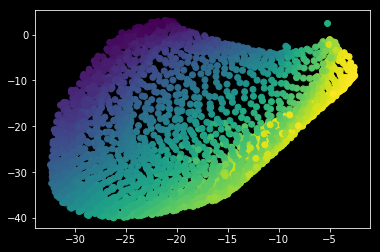

In [246]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=U[:,2], cmap='viridis');

In [243]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

configure_plotly_browser_state()

init_notebook_mode(connected=False)


import plotly.graph_objs as go


trace1 = go.Scatter3d(
    x=latent_sampled_[:,0],
    y=latent_sampled_[:,1],
    z=latent_sampled_[:,2],
    name = 'train data: line',
    mode='markers',
    marker=dict(
        size=3.0,
        color=U[:,0],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)



fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')